In [1]:
import pandas as pd
import numpy as np
import os
import gc
import pickle
import joblib

import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import warnings

base_seed = 0

DEBUG = False

if ~DEBUG:
    warnings.filterwarnings("ignore")

In [3]:
sales = pd.read_csv('./accuracy/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('./accuracy/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('./accuracy/sell_prices.csv')
prices.name = 'prices'

In [4]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [5]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

## Feature Engineering

In [6]:
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [ ]:
# del df
# gc.collect()

In [33]:

## categorical data
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

df.drop('date',axis=1,inplace=True)

## add lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)
    
## add mean
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

## add rolling mean
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## add expanding mean
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

## add trends
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [34]:
df = df[df['d']>=36]
df.to_pickle('data_validation.pkl')
del df
gc.collect()

15

In [37]:
data = pd.read_pickle('data.pkl')
data['d'].describe()

count    5.896766e+07
mean     1.002500e+03
std      5.582976e+02
min      3.600000e+01
25%      5.190000e+02
50%      1.002500e+03
75%      1.486000e+03
max      1.969000e+03
Name: d, dtype: float64

In [38]:
data = pd.read_pickle('data_validation.pkl')
data['d'].describe()

count    5.811394e+07
mean     9.889113e+02
std      5.509266e+02
min      3.600000e+01
25%      5.120000e+02
50%      9.885000e+02
75%      1.465000e+03
max      1.969000e+03
Name: d, dtype: float64

In [39]:
data.dtypes

id                            int16
item_id                       int16
dept_id                        int8
cat_id                         int8
store_id                       int8
state_id                       int8
d                             int16
sold                          int16
wm_yr_wk                      int16
weekday                        int8
wday                           int8
month                          int8
year                          int16
event_name_1                   int8
event_type_1                   int8
event_name_2                   int8
event_type_2                   int8
snap_CA                        int8
snap_TX                        int8
snap_WI                        int8
sell_price                  float16
sold_lag_1                  float16
sold_lag_2                  float16
sold_lag_3                  float16
sold_lag_6                  float16
sold_lag_12                 float16
sold_lag_24                 float16
sold_lag_36                 

In [8]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.841371	training's l2: 0.707905	valid_1's rmse: 0.549692	valid_1's l2: 0.302161
[40]	training's rmse: 0.804525	training's l2: 0.647261	valid_1's rmse: 0.5348	valid_1's l2: 0.286011
[60]	training's rmse: 0.783255	training's l2: 0.613489	valid_1's rmse: 0.52753	valid_1's l2: 0.278288
[80]	training's rmse: 0.764822	training's l2: 0.584952	valid_1's rmse: 0.515422	valid_1's l2: 0.26566
[100]	training's rmse: 0.753176	training's l2: 0.567275	valid_1's rmse: 0.509039	valid_1's l2: 0.259121
[120]	training's rmse: 0.742756	training's l2: 0.551686	valid_1's rmse: 0.508121	valid_1's l2: 0.258187
[140]	training's rmse: 0.732605	training's l2: 0.53671	valid_1's rmse: 0.508102	valid_1's l2: 0.258167
Early stopping, best iteration is:
[124]	training's rmse: 0.741067	training's l2: 0.549181	valid_1's rmse: 0.506912	valid_1's l2: 0.256959
*****Prediction for Store: CA_2*****
Trainin

[80]	training's rmse: 0.719793	training's l2: 0.518101	valid_1's rmse: 0.950355	valid_1's l2: 0.903175
Early stopping, best iteration is:
[77]	training's rmse: 0.721405	training's l2: 0.520426	valid_1's rmse: 0.948383	valid_1's l2: 0.899429
*****Prediction for Store: WI_3*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.815185	training's l2: 0.664527	valid_1's rmse: 0.59894	valid_1's l2: 0.358729
[40]	training's rmse: 0.774146	training's l2: 0.599302	valid_1's rmse: 0.582443	valid_1's l2: 0.33924
Early stopping, best iteration is:
[33]	training's rmse: 0.781853	training's l2: 0.611294	valid_1's rmse: 0.581293	valid_1's l2: 0.337901


In [29]:
valid['sold'] = valid_preds
validation = valid[['id','d','sold']]
validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.id = evaluation.id.map(d_id)
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission_2.csv',index=False)

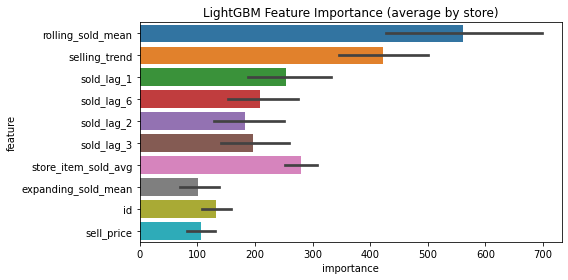

In [9]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('./'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:10].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 4))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Feature Importance (average by store)')
    plt.tight_layout()
    
display_importances(feature_importance_df)